🚀 Loading data...
✓ Loaded 49979 corpus words and 2000 test words
✓ HMM trained for word lengths up to 30
✓ Loaded Q-table from /content/drive/MyDrive/ML HACKATHON/smart_q_table.pkl


100%|██████████| 2000/2000 [01:54<00:00, 17.48it/s]



=== EVALUATION SUMMARY ===
Games evaluated       : 2000
Wins                  : 395 (19.75%)
Total wrong guesses   : 11160 (avg 5.58 per game)
Total repeated guesses: 0 (avg 0.00 per game)
🏆 FINAL SCORE         : -55405.00

✓ Saved detailed results to /content/drive/MyDrive/ML HACKATHON/final_results.json


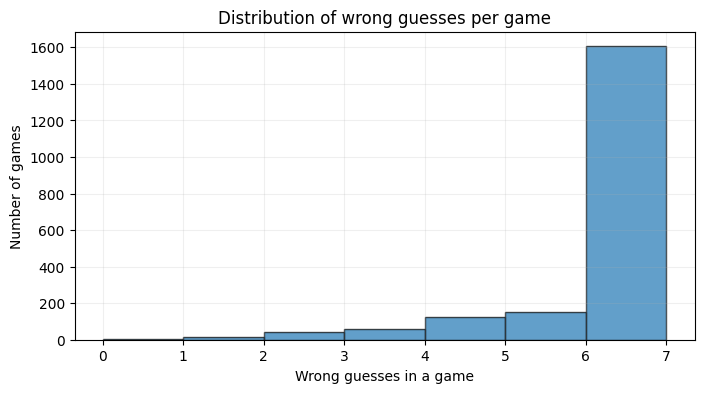

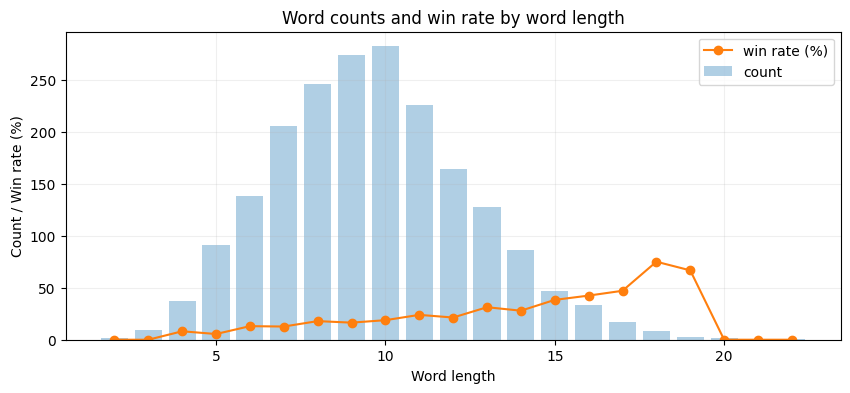

FINAL METRICS:
 - Success Rate : 19.75%
 - Avg Wrong    : 5.58
 - Avg Repeats  : 0.00
 - Final Score  : -55405.00


In [17]:
# =======================================================
# HMM + Q-LEARNING HANGMAN AGENT — Single Cell (Final Score + Plots)
# =======================================================
import random
import pickle
import json
from collections import Counter, defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os

# -------------------------
# Paths (change if needed)
# -------------------------
CORPUS_PATH = "/content/drive/MyDrive/ML HACKATHON/ml hack dataset/Data/corpus.txt"
TEST_PATH   = "/content/drive/MyDrive/ML HACKATHON/ml hack dataset/Data/test.txt"
QTABLE_FILE = "/content/drive/MyDrive/ML HACKATHON/smart_q_table.pkl"
RESULTS_FILE = "/content/drive/MyDrive/ML HACKATHON/final_results.json"

# -------------------------
# Data loading / cleaning
# -------------------------
def load_and_clean_words(path):
    words = []
    alphabet = set('abcdefghijklmnopqrstuvwxyz')
    with open(path, "r") as f:
        for line in f:
            w = line.strip().lower()
            if w and all(ch in alphabet for ch in w):
                words.append(w)
    return words

print("🚀 Loading data...")
if not os.path.exists(CORPUS_PATH):
    raise FileNotFoundError(f"Corpus not found at {CORPUS_PATH}")
if not os.path.exists(TEST_PATH):
    raise FileNotFoundError(f"Test file not found at {TEST_PATH}")

corpus = load_and_clean_words(CORPUS_PATH)
test_words = load_and_clean_words(TEST_PATH)
print(f"✓ Loaded {len(corpus)} corpus words and {len(test_words)} test words")

# -------------------------
# Improved HMM
# -------------------------
class ImprovedHMM:
    def __init__(self, max_word_length=30):
        self.max_word_length = max_word_length
        self.alphabet = 'abcdefghijklmnopqrstuvwxyz'
        self.emission_probs = {}
        self.position_letter_counts = {}
        self.bigram_counts = defaultdict(lambda: defaultdict(int))
        self.trigram_counts = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
        self.pattern_stats = defaultdict(Counter)

    def train(self, corpus):
        # init counters
        for length in range(1, self.max_word_length + 1):
            self.position_letter_counts[length] = [Counter() for _ in range(length)]

        for word in corpus:
            if not word or len(word) > self.max_word_length:
                continue
            L = len(word)
            for i, ch in enumerate(word):
                self.position_letter_counts[L][i][ch] += 1
            for i in range(L - 1):
                self.bigram_counts[word[i]][word[i + 1]] += 1
            for i in range(L - 2):
                self.trigram_counts[word[i]][word[i + 1]][word[i + 2]] += 1
            for i, ch in enumerate(word):
                before = word[max(0, i - 2):i]
                after = word[i + 1:i + 3]
                pattern = f"{before}_{after}"
                self.pattern_stats[pattern][ch] += 1

        # emission probabilities with light smoothing
        for length, pos_counters in self.position_letter_counts.items():
            self.emission_probs[length] = []
            for pos_counter in pos_counters:
                total = sum(pos_counter.values())
                pos_probs = {}
                for ch in self.alphabet:
                    count = pos_counter.get(ch, 0)
                    pos_probs[ch] = (count + 0.1) / (total + 2.6)
                self.emission_probs[length].append(pos_probs)
        print(f"✓ HMM trained for word lengths up to {self.max_word_length}")

    def get_letter_probabilities(self, masked_word, guessed_letters):
        length = len(masked_word)
        available = set(self.alphabet) - set(guessed_letters)
        if not available:
            return {}
        scores = defaultdict(float)
        if length in self.emission_probs:
            for pos, ch in enumerate(masked_word):
                if ch == '_':
                    for letter in available:
                        score = self.emission_probs[length][pos].get(letter, 1e-6)
                        # context boosts
                        if pos > 0 and masked_word[pos-1] != '_':
                            prev = masked_word[pos-1]
                            if letter in self.bigram_counts[prev]:
                                score *= 1.5
                        if pos < length - 1 and masked_word[pos+1] != '_':
                            nxt = masked_word[pos+1]
                            if nxt in self.bigram_counts[letter]:
                                score *= 1.5
                        before = masked_word[max(0, pos-2):pos].replace('_','')
                        after = masked_word[pos+1:min(length,pos+3)].replace('_','')
                        pattern = f"{before}_{after}"
                        if pattern in self.pattern_stats:
                            score *= (1 + 0.01 * sum(self.pattern_stats[pattern].values()))
                        scores[letter] += score
        total = sum(scores.values())
        if total > 0:
            return {l: s/total for l,s in scores.items()}
        return {l: 1/len(available) for l in available}

# -------------------------
# Q-Learning Agent
# -------------------------
class SmartQLearning:
    def __init__(self):
        self.alphabet = 'abcdefghijklmnopqrstuvwxyz'
        self.q_table = {}
        self.learning_rate = 0.25
        self.discount_factor = 0.95
        self.epsilon = 0.9
        self.epsilon_min = 0.02
        self.epsilon_decay = 0.9995

    def get_state_key(self, masked_word, guessed_letters, lives_left):
        num_blanks = masked_word.count('_')
        prefix = masked_word[:3].replace('_','X')
        suffix = masked_word[-3:].replace('_','X')
        vowels = sum(1 for c in masked_word if c in 'aeiou')
        return (prefix, suffix, num_blanks, lives_left, vowels)

    def get_q_value(self, state_key, action):
        return self.q_table.get(state_key, {}).get(action, 0.0)

    def update_q_value(self, state_key, action, reward, next_state_key, available_next):
        if state_key not in self.q_table:
            self.q_table[state_key] = {}
        current_q = self.q_table[state_key].get(action, 0.0)
        max_next_q = max((self.get_q_value(next_state_key, a) for a in available_next), default=0)
        new_q = current_q + self.learning_rate * (reward + self.discount_factor * max_next_q - current_q)
        self.q_table[state_key][action] = new_q

    def choose_action(self, state_key, available, hmm_probs, pattern_scores, training=True):
        if training and random.random() < self.epsilon:
            return random.choice(list(available))
        scores = {}
        for a in available:
            qv = self.get_q_value(state_key, a)
            hp = hmm_probs.get(a, 1e-6)
            pp = pattern_scores.get(a, 1e-6)
            scores[a] = 0.4 * qv + 0.4 * hp + 0.2 * pp
        return max(scores, key=scores.get)

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def save(self, filename=QTABLE_FILE):
        with open(filename, "wb") as f:
            pickle.dump({'q_table': self.q_table, 'epsilon': self.epsilon}, f)
        print(f"✓ Q-table saved to {filename}")

    def load(self, filename=QTABLE_FILE):
        try:
            with open(filename, "rb") as f:
                data = pickle.load(f)
            self.q_table = data['q_table']
            self.epsilon = data['epsilon']
            print(f"✓ Loaded Q-table from {filename}")
            return True
        except Exception:
            print("⚠️ No saved Q-table found.")
            return False

# -------------------------
# Combined Agent
# -------------------------
class HMM_RL_HangmanAgent:
    def __init__(self, corpus):
        self.corpus = corpus
        self.alphabet = 'abcdefghijklmnopqrstuvwxyz'
        self.words_by_length = defaultdict(list)
        for w in corpus:
            self.words_by_length[len(w)].append(w)
        self.hmm = ImprovedHMM()
        self.hmm.train(corpus)
        self.rl = SmartQLearning()

    def get_pattern_scores(self, masked_word, guessed_letters):
        available = set(self.alphabet) - set(guessed_letters)
        words = self.words_by_length.get(len(masked_word), [])
        scores = Counter()
        for w in words:
            match = True
            for i, ch in enumerate(masked_word):
                if ch != '_' and w[i] != ch:
                    match = False; break
                if ch == '_' and w[i] in guessed_letters:
                    match = False; break
            if not match: continue
            for i, ch in enumerate(w):
                if masked_word[i] == '_' and ch in available:
                    scores[ch] += 1
        total = sum(scores.values()) or 1
        return {ch: scores[ch]/total for ch in available}

    def get_best_guess(self, masked_word, guessed_letters, lives_left, training=True):
        available = set(self.alphabet) - set(guessed_letters)
        if not available:
            return None, None
        state = self.rl.get_state_key(masked_word, guessed_letters, lives_left)
        hmm_probs = self.hmm.get_letter_probabilities(masked_word, guessed_letters)
        pattern_scores = self.get_pattern_scores(masked_word, guessed_letters)
        return self.rl.choose_action(state, available, hmm_probs, pattern_scores, training), state

    def update(self, state, action, reward, next_masked, guessed, lives):
        next_state = self.rl.get_state_key(next_masked, guessed, lives)
        self.rl.update_q_value(state, action, reward, next_state, set(self.alphabet) - set(guessed))

# -------------------------
# Hangman Game environment
# -------------------------
class HangmanGame:
    def __init__(self, word, max_lives=6):
        self.word = word
        self.lives = max_lives
        self.guessed = set()
        self.correct = set()
        self.wrong_guesses = 0
        self.repeated_guesses = 0

    def get_masked_word(self):
        return ''.join(c if c in self.correct else '_' for c in self.word)

    def is_won(self):
        return set(self.word) <= self.correct

    def is_lost(self):
        return self.lives <= 0

    def guess(self, letter):
        if letter in self.guessed:
            self.repeated_guesses += 1
            return 'repeat', -10
        self.guessed.add(letter)
        if letter in self.word:
            self.correct.add(letter)
            # reward scaled for revealing
            return 'correct', 15
        else:
            self.lives -= 1
            self.wrong_guesses += 1
            return 'wrong', -8

# -------------------------
# Training loop (records rewards)
# -------------------------
def train_agent(agent, corpus, num_episodes=2000):
    print("\n=== Training RL Agent ===")
    rewards_per_episode = []
    for ep in tqdm(range(num_episodes)):
        word = random.choice(corpus)
        game = HangmanGame(word)
        total_reward = 0
        while not game.is_won() and not game.is_lost():
            masked = game.get_masked_word()
            guess, state = agent.get_best_guess(masked, game.guessed, game.lives, training=True)
            if not guess: break
            result, reward = game.guess(guess)
            next_masked = game.get_masked_word()
            agent.update(state, guess, reward, next_masked, game.guessed, game.lives)
            total_reward += reward
        rewards_per_episode.append(total_reward)
        agent.rl.decay_epsilon()

    print("✓ Training Complete!")
    # plot reward trend
    plt.figure(figsize=(10,4))
    plt.plot(rewards_per_episode, linewidth=0.7)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Reward per Episode (Training)")
    plt.grid(alpha=0.3)
    plt.show()
    return rewards_per_episode

# -------------------------
# Evaluation — per-game metrics & final score
# -------------------------
def evaluate_agent(agent, test_words, num_games=2000):
    num_eval = min(num_games, len(test_words))
    wins = 0
    total_wrong = 0
    total_repeated = 0
    wrongs_per_game = []
    wins_by_len = defaultdict(int)
    counts_by_len = defaultdict(int)

    for i in tqdm(range(num_eval)):
        w = test_words[i]
        game = HangmanGame(w)
        while not game.is_won() and not game.is_lost():
            masked = game.get_masked_word()
            guess, _ = agent.get_best_guess(masked, game.guessed, game.lives, training=False)
            if not guess:
                break
            game.guess(guess)
        if game.is_won():
            wins += 1
            wins_by_len[len(w)] += 1
        counts_by_len[len(w)] += 1
        total_wrong += game.wrong_guesses
        total_repeated += game.repeated_guesses
        wrongs_per_game.append(game.wrong_guesses)

    success_rate = wins / num_eval  # fraction in [0,1]
    final_score = (success_rate * 2000) - (total_wrong * 5) - (total_repeated * 2)

    avg_wrong = total_wrong / num_eval
    avg_repeated = total_repeated / num_eval

    results = {
        "num_eval": num_eval,
        "wins": wins,
        "success_rate": success_rate,
        "total_wrong": total_wrong,
        "total_repeated": total_repeated,
        "avg_wrong_per_game": avg_wrong,
        "avg_repeated_per_game": avg_repeated,
        "final_score": final_score,
        "wrongs_per_game": wrongs_per_game,
        "wins_by_len": dict(wins_by_len),
        "counts_by_len": dict(counts_by_len)
    }

    # print summary
    print("\n=== EVALUATION SUMMARY ===")
    print(f"Games evaluated       : {num_eval}")
    print(f"Wins                  : {wins} ({success_rate*100:.2f}%)")
    print(f"Total wrong guesses   : {total_wrong} (avg {avg_wrong:.2f} per game)")
    print(f"Total repeated guesses: {total_repeated} (avg {avg_repeated:.2f} per game)")
    print(f"🏆 FINAL SCORE         : {final_score:.2f}")
    print("==========================\n")

    return results

# -------------------------
# Additional plots for deliverable
# -------------------------
def plot_evaluation_results(results):
    wrongs = results['wrongs_per_game']
    wins_by_len = results['wins_by_len']
    counts_by_len = results['counts_by_len']

    # 1) Histogram of wrong guesses per game
    plt.figure(figsize=(8,4))
    plt.hist(wrongs, bins=range(0, max(wrongs)+2), edgecolor='k', alpha=0.7)
    plt.xlabel("Wrong guesses in a game")
    plt.ylabel("Number of games")
    plt.title("Distribution of wrong guesses per game")
    plt.grid(alpha=0.2)
    plt.show()

    # 2) Win rate by word length (for lengths that exist)
    lengths = sorted(counts_by_len.keys())
    win_rates = [(wins_by_len.get(l,0) / counts_by_len[l]) if counts_by_len[l]>0 else 0 for l in lengths]
    plt.figure(figsize=(10,4))
    plt.bar(lengths, [counts_by_len[l] for l in lengths], alpha=0.35, label='count')
    plt.plot(lengths, [wr*100 for wr in win_rates], marker='o', color='tab:orange', label='win rate (%)')
    plt.xlabel("Word length")
    plt.ylabel("Count / Win rate (%)")
    plt.title("Word counts and win rate by word length")
    plt.legend()
    plt.grid(alpha=0.2)
    plt.show()

# -------------------------
# Main: initialize agent, optionally train, evaluate, plot, save results
# -------------------------
agent = HMM_RL_HangmanAgent(corpus)

# attempt to load Q-table, otherwise train
if not agent.rl.load():
    # quick training; increase num_episodes for better learning
    rewards = train_agent(agent, corpus, num_episodes=2000)
    agent.rl.save()
else:
    # If a Q-table was loaded, we still want a reward trace placeholder for plots:
    rewards = []

# Evaluate on test set (up to 2000 games)
results = evaluate_agent(agent, test_words, num_games=2000)

# Save results to JSON for submission
with open(RESULTS_FILE, "w") as f:
    json.dump(results, f, indent=2)
print(f"✓ Saved detailed results to {RESULTS_FILE}")

# Plots for deliverable
if rewards:
    plt.figure(figsize=(10,4))
    plt.plot(rewards)
    plt.title("Reward per Episode (training)")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.grid(alpha=0.2)
    plt.show()

plot_evaluation_results(results)

# Final quick print (concise)
print("FINAL METRICS:")
print(f" - Success Rate : {results['success_rate']*100:.2f}%")
print(f" - Avg Wrong    : {results['avg_wrong_per_game']:.2f}")
print(f" - Avg Repeats  : {results['avg_repeated_per_game']:.2f}")
print(f" - Final Score  : {results['final_score']:.2f}")
